In [107]:
# Standard libraries
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
path3p = os.path.dirname(path2p)
libpath = os.path.join(path2p, "lib")
pwd_rez = os.path.join(path3p, "data")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from data_io.qt_wrapper import gui_fname, gui_fpath
from data_io.yaro.yaro_data_read import read_neuro_perf
import data_io.yaro.yaro_te_h5_lib as yaro_te_h5_lib


%load_ext autoreload
%autoreload 2

Appended library directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity/codes/lib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
'''
1. Load curve of DF/F for one mouse/day
2. Load TE for same day
3. Plot TE
4. Select low and high TE steps
5. Plot phase space for the two steps
'''

In [5]:
datafile_path  = gui_fpath("Mouse data path", "./")
te_file_path = gui_fname("TE file", datafile_path, "HDF5 (*.h5)")

In [32]:
summary = {
    "max_lag" : 5,
    "window" : 6,
    "timestep" : 0.2
}

data_dff, behaviour, performance = read_neuro_perf(datafile_path, verbose=False)
times_te, data_te = yaro_te_h5_lib.readTE_H5(te_file_path, summary)

Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/swipe/subsampled_delay_5_window_6/mtp_15_2018_06_04_a_iGO_BivariateTE_swipe.h5


TE index 19 has TE 0.11 at time 4.800000000000001 with lag 2
data index 96 is at time 4.800000000000001
CORR= 0.2090952283685903
TE index 33 has TE 0.0 at time 7.6000000000000005 with lag 2
data index 152 is at time 7.6000000000000005
CORR= 0.07383682282791947


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


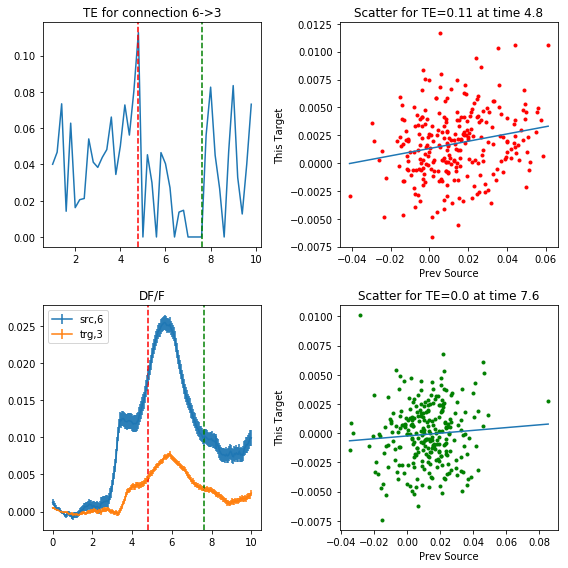

In [151]:
%matplotlib inline
CHANNEL_SRC = 6
CHANNEL_TRG = 3

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)

#############################
# Plot mean TE for SRC-> TRG
#############################
te, lag, p = data_te
p[np.isnan(p)] = 100
p[p > 0.01] = np.nan
te[np.isnan(p)] = 0
lag[np.isnan(p)] = 0

nChannel, _, nTimes = te.shape
ax[0,0].set_title("TE for connection " + str(CHANNEL_SRC) +'->'+str(CHANNEL_TRG))
ax[0,0].plot(times_te, te[CHANNEL_SRC, CHANNEL_TRG])

#############################
# Plot mean TE for SRC-> TRG
#############################
data_dff_go = data_dff[behaviour['iGO']-1]
nTrialGO, nTimesGo, _ = data_dff_go.shape
times_dff = np.linspace(0, nTimesGo-1, nTimesGo) * 0.05

data_dff_go_src = data_dff_go[:,:,CHANNEL_SRC]
data_dff_go_trg = data_dff_go[:,:,CHANNEL_TRG]
data_dff_go_src_mu = np.mean(data_dff_go_src, axis=0)
data_dff_go_trg_mu = np.mean(data_dff_go_trg, axis=0)
data_dff_go_src_stdmu = np.std(data_dff_go_src, axis=0) / np.sqrt(nTrialGO)
data_dff_go_trg_stdmu = np.std(data_dff_go_trg, axis=0) / np.sqrt(nTrialGO)

ax[1,0].set_title("DF/F")
ax[1,0].errorbar(times_dff, data_dff_go_src_mu, data_dff_go_src_stdmu, label="src,"+str(CHANNEL_SRC))
ax[1,0].errorbar(times_dff, data_dff_go_trg_mu, data_dff_go_trg_stdmu, label="trg,"+str(CHANNEL_TRG))
ax[1,0].legend()

#############################
# Plot 2D phase space
#############################
zscore = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
lag_this = 2
for iPlot, (idxTE, idxData, color) in enumerate(zip([19, 33], [96, 152], ['r', 'g'])):
    te_this = np.round(te[CHANNEL_SRC, CHANNEL_TRG][idxTE], 2)
    #lag_this = int(lag[CHANNEL_SRC, CHANNEL_TRG][idxTE])
    time_this = np.round(times_te[idxTE], 2)
    print("TE index", idxTE, "has TE", te_this, "at time", times_te[idxTE], "with lag", lag_this)
    print("data index", idxData, "is at time", times_dff[idxData])
    
    ax[0,0].axvline(x=time_this, color=color, linestyle='--')
    ax[1,0].axvline(x=time_this, color=color, linestyle='--')

    dataTrialsSrcPrev = data_dff_go_src[:, idxData-lag_this*4]
    dataTrialsTrgPrev = data_dff_go_trg[:, idxData-lag_this*4]
    dataTrialsTrgThis = data_dff_go_trg[:, idxData]
    
    # Subtract linear effect of past on present
    trgFitCoeff = np.polyfit(dataTrialsTrgPrev, dataTrialsTrgThis, 1)
    dataTrialsTrgSub = dataTrialsTrgThis - dataTrialsTrgPrev*trgFitCoeff[0]
    
    # Compute correlation of the remainder and fit line
    srcFitCoeff = np.polyfit(dataTrialsSrcPrev, dataTrialsTrgSub, 1)
    xFit = np.linspace(np.min(dataTrialsSrcPrev), np.max(dataTrialsSrcPrev), 100)
    yFit = xFit * srcFitCoeff[0] + srcFitCoeff[1]
    print("CORR=", np.corrcoef(dataTrialsSrcPrev, dataTrialsTrgSub)[0,1])
    
    ax[iPlot, 1].set_title("Scatter for TE="+str(te_this)+" at time "+str(time_this))
    ax[iPlot, 1].plot(dataTrialsSrcPrev, dataTrialsTrgSub, '.', color=color)
    ax[iPlot, 1].plot(xFit, yFit)
    
    #colors = zscore(dataTrialsTrgPrev)
#     for x,y,c in zip(dataTrialsSrcPrev, dataTrialsTrgThis, colors):
#         ax[iPlot, 1].plot(x, y, '.', color=(c, 0, 1-c))
    ax[iPlot, 1].set_xlabel("Prev Source")
    ax[iPlot, 1].set_ylabel("This Target")
plt.show()